## Le meilleur score jusqu'à là

In [1]:
import pandas as pd
import numpy as np
import re
from lightgbm import LGBMClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train_data = pd.read_hdf("/content/drive/MyDrive/PROJET fin L2 - Trading/train_data_j3_evelina.h5", 'data')
labels = pd.read_csv("/content/drive/MyDrive/PROJET fin L2 - Trading/train_labels.csv")
test_data = pd.read_hdf("/content/drive/MyDrive/PROJET fin L2 - Trading/test_data_j3_evelina.h5", 'data')

In [3]:
labels.set_index('ID', inplace=True)
labels = labels.loc[train_data.index]

In [4]:
labels

,source_id
ID,
0,2
1,2
2,2
3,4
4,2
...,...
959501,4
959502,1
959503,3


## Train test split

In [37]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_data, labels, test_size=0.2, random_state=42)

In [38]:
# 5. Colonnes catégorielles
categorical_features = [
    'venue_with_max_bidsize', 'venue_with_max_asksize',
    'venue_with_best_bid', 'venue_with_best_ask',
    'venue_with_min_spread', 'venue_with_min_spread1'
]

In [39]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

model_1 = LGBMClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42)
model_1.fit(x_train, y_train, categorical_feature=categorical_features)

y_pred = model_1.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.492378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25918
[LightGBM] [Info] Number of data points in the train set: 767604, number of used features: 129
[LightGBM] [Info] Start training from score -3.373629
[LightGBM] [Info] Start training from score -1.833947
[LightGBM] [Info] Start training from score -1.325007
[LightGBM] [Info] Start training from score -2.071123
[LightGBM] [Info] Start training from score -1.085015
[LightGBM] [Info] Start training from score -2.574247
Accuracy: 0.5054402768079541


# Matrice de confusion


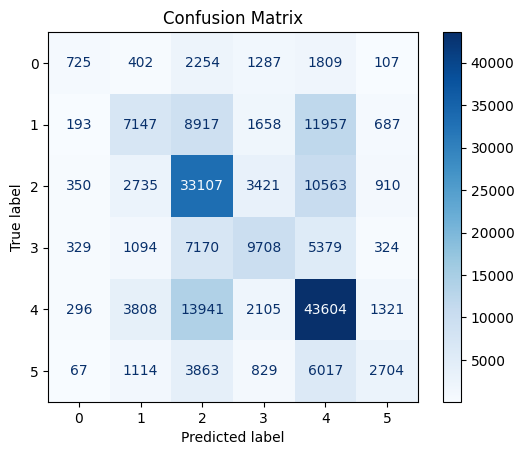

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_test = les vrais labels
# y_pred = les prédictions du modèle

cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4, 5])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

Sur la diagonale on a les bons résultats, c'est-à-dire les prédictions correctes. On remarque que le modèle prédit assez bien pour le marché 4 et 2.

Hors-diagonale, on voit que la vrai valeur est de 4, mais le model a prédit 2.
On voit qu'il confond souvent 2 et 4, et predit souvent 4 ce qui signifie que les features ne se différenient pas bien. Il serait peut-être interressant d'ajouter des features plus discriminantes.

#### Remarques:
- Le modèle a du mal à reconnaître la classe 0
- Le modèle confond 2 avec 4 et 1 .
- Le modèle reconnaît très bien la classe 4.
- Le modèle confond souvent la 5 avec la 2 et la 4.

In [30]:
from sklearn.model_selection import train_test_split

y = labels.values.ravel()

x_train, x_test, y_train, y_test = train_test_split(train_data, y, test_size=0.2, random_state=42)

In [31]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcul des poids
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# Dictionnaire : {classe: poids}
class_weights = dict(zip(classes, weights))
print("Poids par classe :", class_weights)

Poids par classe : {np.int64(0): np.float64(4.864040757356855), np.int64(1): np.float64(1.0430904450912768), np.int64(2): np.float64(0.6270352399156987), np.int64(3): np.float64(1.3222879113610055), np.int64(4): np.float64(0.49324712477493626), np.int64(5): np.float64(2.1869059829059827)}


In [33]:
# Associer chaque ligne à son poids selon la classe
sample_weights = [class_weights[cls] for cls in y_train]

# Modèle
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)

# Entraînement avec sample_weight
model.fit(x_train, y_train, sample_weight=sample_weights, categorical_feature=categorical_features)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.488440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25918
[LightGBM] [Info] Number of data points in the train set: 767604, number of used features: 129
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


LGBMClassifier(max_depth=10, n_estimators=200, random_state=42)

In [34]:
y_pred_poids = model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred_poids))

Accuracy: 0.44132942856249546


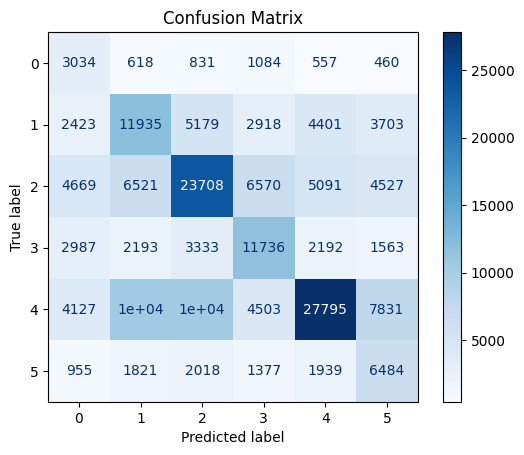

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_test = les vrais labels
# y_pred = les prédictions du modèle

cm = confusion_matrix(y_test, y_pred_poids, labels=[0, 1, 2, 3, 4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4, 5])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

## Essayons les 2 modèles

In [41]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Prédistributions de probas sur X_test
probas_1 = model_1.predict_proba(x_test)
probas_2 = model.predict_proba(x_test)

# 2. Moyenne pondérée (tu peux ajuster les poids)
alpha = 0.5  # 50/50 (peut être 0.6/0.4, etc.)
blended_probas = alpha * probas_1 + (1 - alpha) * probas_2

# 3. Prédictions finales (classe avec la proba la plus haute)
y_pred_blend = np.argmax(blended_probas, axis=1)

# 4. Évaluation
acc = accuracy_score(y_test, y_pred_blend)
print(f"✅ Accuracy du blending : {acc:.4f}")

✅ Accuracy du blending : 0.4922


✅ Accuracy du blending : 0.4922

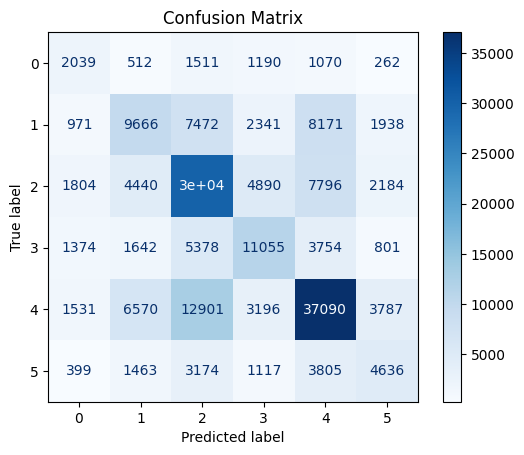

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_test = les vrais labels
# y_pred = les prédictions du modèle

cm = confusion_matrix(y_test, y_pred_blend, labels=[0, 1, 2, 3, 4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4, 5])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

Soumissions

In [44]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Prédistributions de probas sur X_test
probas_1 = model_1.predict_proba(test_data)
probas_2 = model.predict_proba(test_data)

# 2. Moyenne pondérée (tu peux ajuster les poids)
alpha = 0.5  # 50/50 (peut être 0.6/0.4, etc.)
blended_probas = alpha * probas_1 + (1 - alpha) * probas_2

# 3. Prédictions finales (classe avec la proba la plus haute)
y_pred_blend_test = np.argmax(blended_probas, axis=1)

y_pred_blend_test

array([4, 5, 4, ..., 4, 4, 2])

In [46]:
y_pred_blend_test = pd.Series(y_pred_blend_test, index=test_data.index, name='prediction')
y_pred_blend_test.to_csv('predictions_blend.csv', index=True)